### Main Notebook for visualisation 

Setup for required libraries:

In [2]:
%pip install numpy pandas matplotlib keras scikit-learn tensorflow networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.5 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


Importing data for DNN training (using Pandas):

In [3]:
import pandas as pd
import numpy as np

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'


df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)



In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, LSTM
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(7)

2023-10-23 17:12:16.201121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating data for graph layout using Networkx:

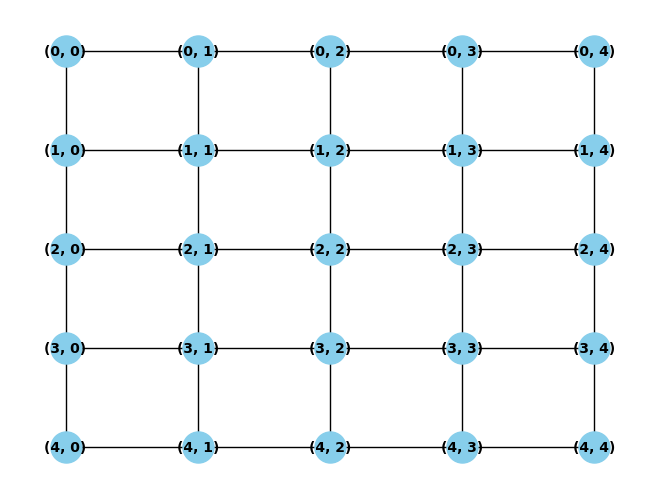

(25, 25)

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a 5x5 grid graph
G = nx.grid_2d_graph(5, 5)

# Plot the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

plt.axis('off')
plt.show()

adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = adjacency_matrix.toarray()
adjacency_matrix.shape

For all nodes:

In [152]:
N = len(df_vel.T)-1

vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1]
idle_data[idle_data < 0] = np.nan

vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df = df.dropna()

threshold = 50

for col in range(N*3,N*4):

    df.iloc[df.iloc[:, col] < threshold, col] = 0
    df.iloc[df.iloc[:, col] >= threshold, col] = 1
df.iloc[:,75:100]



/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_7733/3979858448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle_data[idle_data < 0] = np.nan
/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_7733/3979858448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle_data[idle_data < 0] = np.nan


,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
154,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
155,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
156,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
157,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
158,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Train and test split:

In [154]:
dataset = df.to_numpy()
# dataset[2] = scaler.fit_transform(dataset[2])


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
df.iloc[:,75:100].value_counts()
# df.iloc[:,75:100]
# df.iloc[:,50:75]




14869 6373


1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25 
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0    87
          1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0    84
          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0    76
          1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0    66
                                        1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    64
                                                                                                                               ..
                    0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0

In [168]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:-N]
		dataX.append(a)
		dataY.append(dataset[i + look_back, N*3:N*4])
	return np.array(dataX), np.array(dataY)

look_back = 50

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainY.shape)

(14818, 25)


In [169]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[-1]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[-1]))
# trainY = np.reshape(trainY, (trainY.shape[0], 1, trainY.shape[-1]))
# testY = np.reshape(testY, (testY.shape[0], 1, testY.shape[-1]))

trainY.shape


(14818, 25)

In [172]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[-1])))
model.add(Dense(25, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
14818/14818 - 97s - loss: 0.4713 - accuracy: 0.0225 - 97s/epoch - 7ms/step
Epoch 2/10
14818/14818 - 97s - loss: 0.4380 - accuracy: 0.0319 - 97s/epoch - 7ms/step
Epoch 3/10
14818/14818 - 95s - loss: 0.4330 - accuracy: 0.0286 - 95s/epoch - 6ms/step
Epoch 4/10
14818/14818 - 97s - loss: 0.4315 - accuracy: 0.0383 - 97s/epoch - 7ms/step
Epoch 5/10
14818/14818 - 95s - loss: 0.4309 - accuracy: 0.0355 - 95s/epoch - 6ms/step
Epoch 6/10
14818/14818 - 95s - loss: 0.4296 - accuracy: 0.0366 - 95s/epoch - 6ms/step
Epoch 7/10
14818/14818 - 97s - loss: 0.4281 - accuracy: 0.0489 - 97s/epoch - 7ms/step
Epoch 8/10
14818/14818 - 89s - loss: 0.4260 - accuracy: 0.0551 - 89s/epoch - 6ms/step
Epoch 9/10
14818/14818 - 88s - loss: 0.4253 - accuracy: 0.0744 - 88s/epoch - 6ms/step
Epoch 10/10
14818/14818 - 90s - loss: 0.4253 - accuracy: 0.0796 - 90s/epoch - 6ms/step


#### Data output:

In [254]:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict.max())
# Apply a threshold to convert the probabilities to binary predictions (0 or 1)
threshold = 0.5 # Adjust the threshold if needed
trainPredict_binary = (trainPredict > threshold).astype(int)
testPredict_binary = (testPredict > threshold).astype(int)


198/198 [==============================] - 1s 4ms/step
0.8511668


#### Accuracy Measures and counts of succesful, failed and missed attacks:

In [255]:
from sklearn.metrics import accuracy_score, f1_score

# Compute accuracy and F1 score

flattened_trainPredict_binary = trainPredict_binary.ravel()
flattened_testPredict_binary = testPredict_binary.ravel()

flattened_trainY = trainY.ravel()
flattened_testY = testY.ravel()

train_accuracy = accuracy_score(flattened_trainY, flattened_trainPredict_binary)
test_accuracy = accuracy_score(flattened_testY, flattened_testPredict_binary)

train_f1_score = f1_score(flattened_trainY, flattened_trainPredict_binary)
test_f1_score = f1_score(flattened_testY, flattened_testPredict_binary)

print('Train Accuracy for average:', train_accuracy)
print('Test Accuracy for average:', test_accuracy)

print('Train F1 Score for average: ', train_f1_score)
print('Test F1 Score for average: ', test_f1_score)

Train Accuracy for average: 0.8040761236334188
Test Accuracy for average: 0.8016197405884213
Train F1 Score for average:  0.5382246653433094
Test F1 Score for average:  0.5269891078055698


In [256]:

all_train_actions = pd.DataFrame(flattened_trainPredict_binary)
check_all_train_actions = pd.concat([all_train_actions,pd.DataFrame(flattened_trainY)],axis=1)
all_test_actions = pd.DataFrame(flattened_testPredict_binary)
check_all_test_actions = pd.concat([all_test_actions,pd.DataFrame(flattened_testY)],axis=1)


train_attacks = check_all_train_actions[check_all_train_actions.iloc[:,0] == 1]
train_no_actions = check_all_train_actions[check_all_train_actions.iloc[:,0] == 0]
test_attacks = check_all_test_actions[check_all_test_actions.iloc[:,0] == 1]
test_no_actions = check_all_test_actions[check_all_test_actions.iloc[:,0] == 0]


train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
train_failed = len(train_attacks)-train_success
train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
test_failed = len(test_attacks)-test_success
test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()


print('\nFor Training: ')
print('- Number of succesful attacks:', train_success)
print('- Number of failed attacks:', train_failed)
print('- Number of missed attacks:', train_missed)

print('\nFor Testing: ')
print('- Number of succesful attacks:', test_success)
print('- Number of failed attacks:', test_failed)
print('- Number of missed attacks:', test_missed)




For Training: 
- Number of succesful attacks: 42298
- Number of failed attacks: 20612
- Number of missed attacks: 51968

For Testing: 
- Number of succesful attacks: 17466
- Number of failed attacks: 9218
- Number of missed attacks: 22136


#### Checks for each node individually:

In [261]:
for node in range(0,N-1):
    train_accuracy = accuracy_score(trainY[:,node], trainPredict_binary[:,node])
    test_accuracy = accuracy_score(testY[:,node], testPredict_binary[:,node])

    train_f1_score = f1_score(trainY[:,node], trainPredict_binary[:,node])
    test_f1_score = f1_score(testY[:,node], testPredict_binary[:,node])

    print('\n\nnode: ', node+1)

    print('\nTrain Accuracy for node:', node+1, 'is:' ,train_accuracy)
    print('Test Accuracy for node:', node+1, 'is:' ,test_accuracy)

    print('\nTrain F1 Score for node: ', node+1, 'is:', train_f1_score)
    print('Test F1 Score for node: ', node+1, 'is:', test_f1_score)



node:  1

Train Accuracy for node: 1 is: 0.951950330678904
Test Accuracy for node: 1 is: 0.9550775071180007

Train F1 Score for node:  1 is: 0.0
Test F1 Score for node:  1 is: 0.0


node:  2

Train Accuracy for node: 2 is: 0.982116344985828
Test Accuracy for node: 2 is: 0.9844985763998735

Train F1 Score for node:  2 is: 0.0
Test F1 Score for node:  2 is: 0.0


node:  3

Train Accuracy for node: 3 is: 0.6800512889728708
Test Accuracy for node: 3 is: 0.6426763682378994

Train F1 Score for node:  3 is: 0.607435621429163
Test F1 Score for node:  3 is: 0.5538218447560734


node:  4

Train Accuracy for node: 4 is: 0.7966662167633959
Test Accuracy for node: 4 is: 0.7842454919329326

Train F1 Score for node:  4 is: 0.7813656483564329
Test F1 Score for node:  4 is: 0.7650706166035135


node:  5

Train Accuracy for node: 5 is: 0.7467269537049535
Test Accuracy for node: 5 is: 0.7652641569123695

Train F1 Score for node:  5 is: 0.7450234390923296
Test F1 Score for node:  5 is: 0.760722347629796

In [258]:
for node in range(0,N-1):
    train_actions = pd.DataFrame(trainPredict_binary[:,node])
    check_train_actions = pd.concat([train_actions,pd.DataFrame(trainY[:,node])],axis=1)
    test_actions = pd.DataFrame(testPredict_binary[:,node])
    check_test_actions = pd.concat([test_actions,pd.DataFrame(testY[:,node])],axis=1)


    train_attacks = check_train_actions[check_train_actions.iloc[:,0] == 1]
    train_no_actions = check_train_actions[check_train_actions.iloc[:,0] == 0]
    test_attacks = check_test_actions[check_test_actions.iloc[:,0] == 1]
    test_no_actions = check_test_actions[check_test_actions.iloc[:,0] == 0]


    train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
    train_failed = len(train_attacks)-train_success
    train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
    test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
    test_failed = len(test_attacks)-test_success
    test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()


    print('\n\nNode: ', node+1)
    print('\nFor Training: ')
    print('- Number of succesful attacks:', train_success)
    print('- Number of failed attacks:', train_failed)
    print('- Number of missed attacks:', train_missed)

    print('For Testing: ')
    print('- Number of succesful attacks:', test_success)
    print('- Number of failed attacks:', test_failed)
    print('- Number of missed attacks:', test_missed)



Node:  1

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 712
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 284


Node:  2

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 265
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 98


Node:  3

For Training: 
- Number of succesful attacks: 3668
- Number of failed attacks: 2996
- Number of missed attacks: 1745
For Testing: 
- Number of succesful attacks: 1402
- Number of failed attacks: 1487
- Number of missed attacks: 772


Node:  4

For Training: 
- Number of succesful attacks: 5384
- Number of failed attacks: 1504
- Number of missed attacks: 1509
For Testing: 
- Number of succesful attacks: 2221
- Number of failed attacks: 768
- Number of missed attacks: 596


Node:  5

For Training: 
- Number of succesful att

#### Graphs for another form of visualisation (blue is actual opportunity to attack, red is adversary actions):

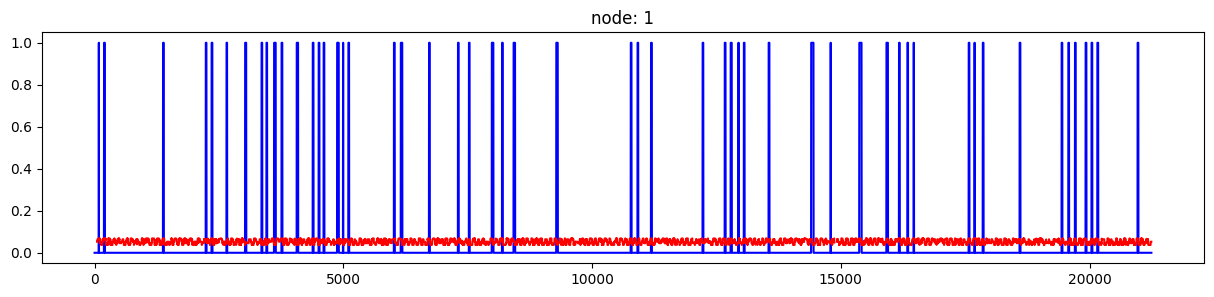

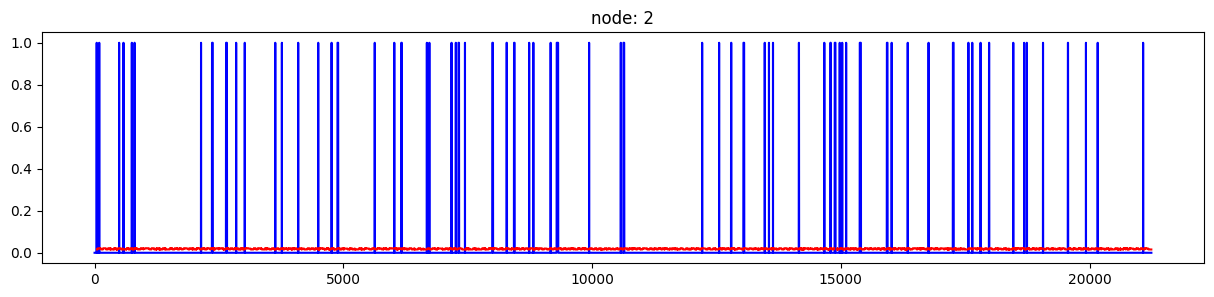

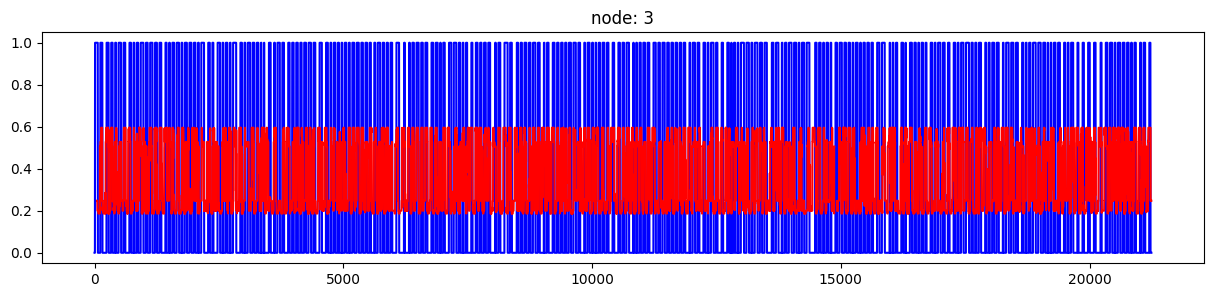

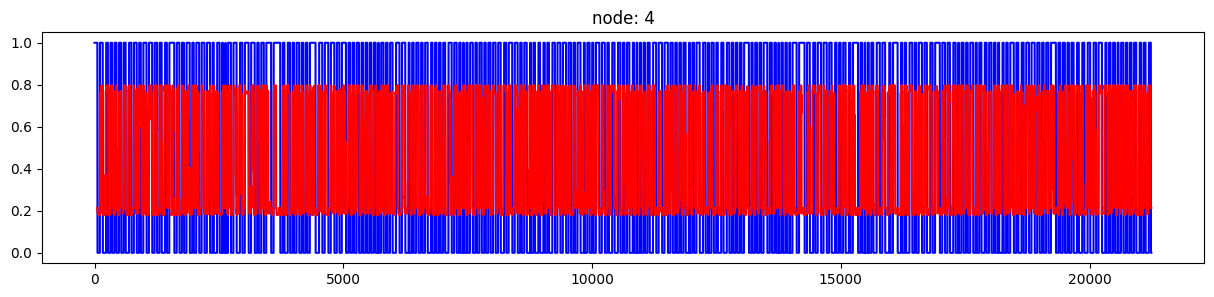

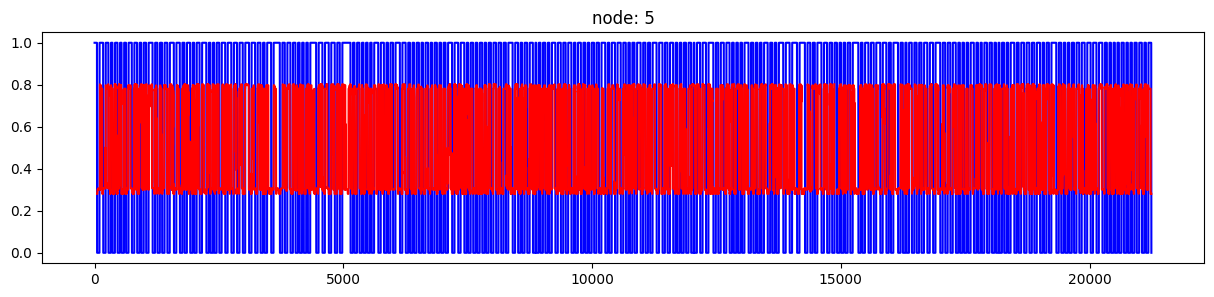

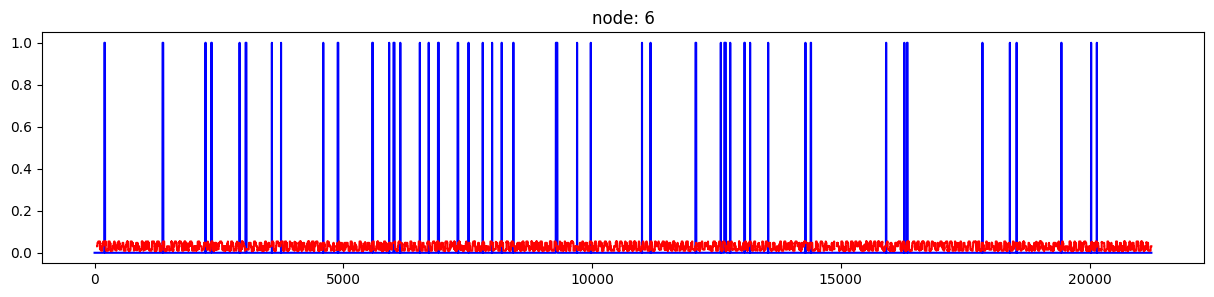

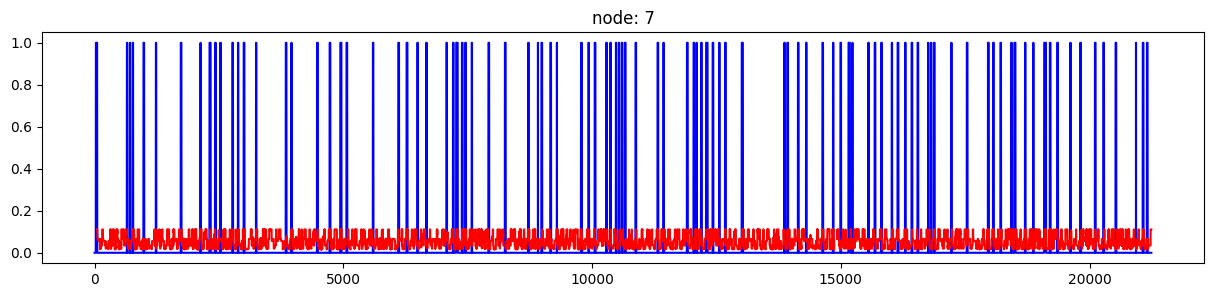

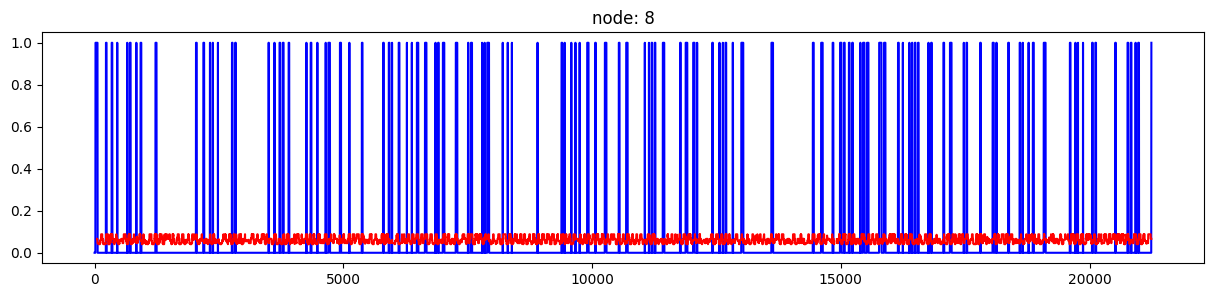

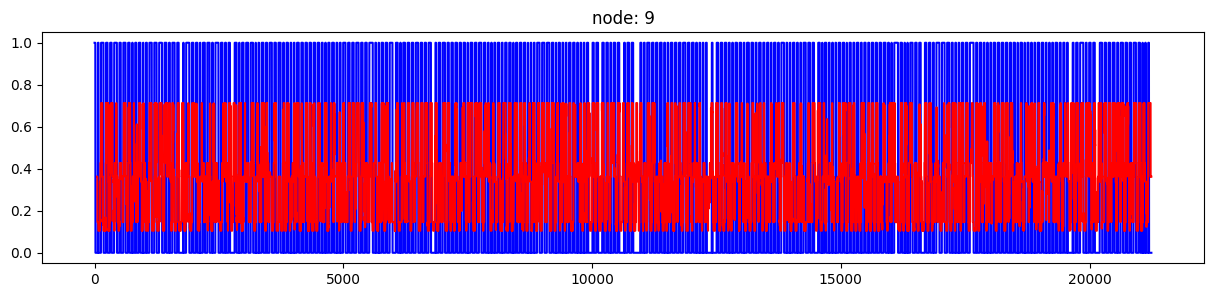

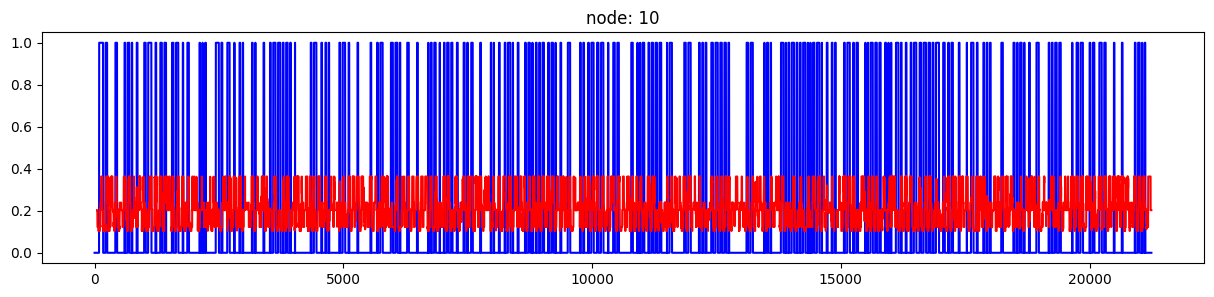

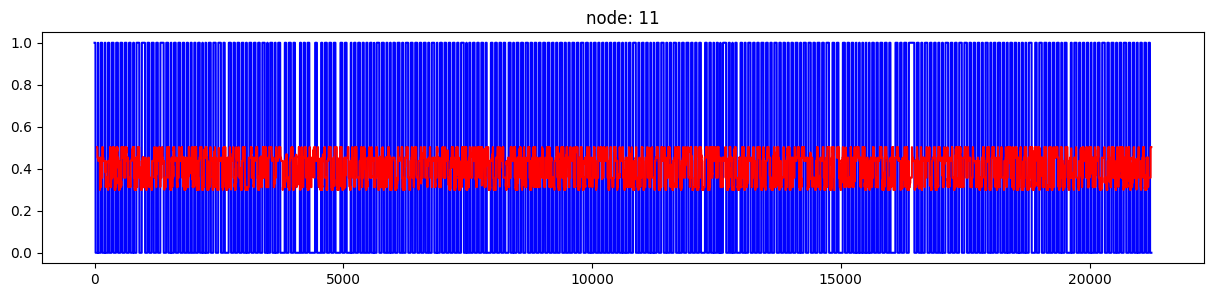

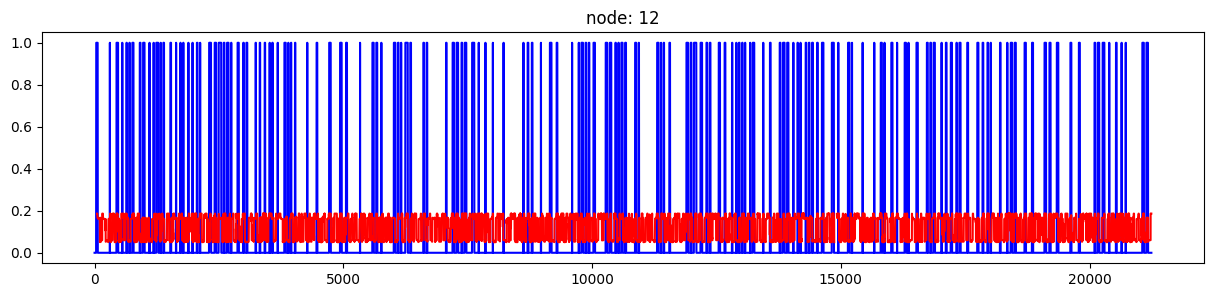

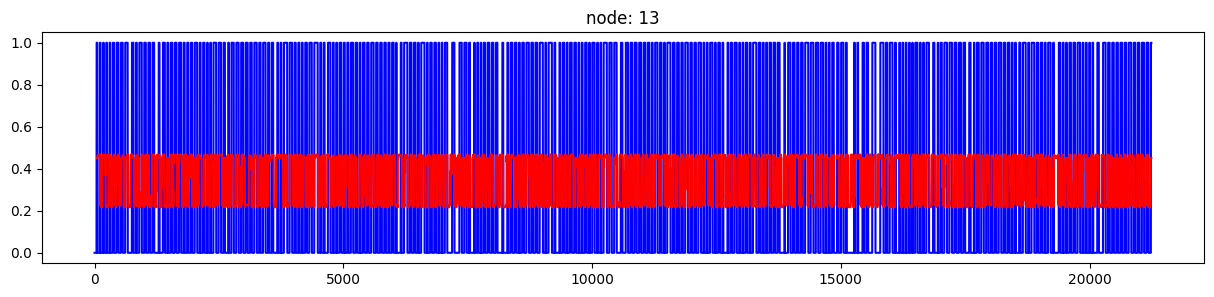

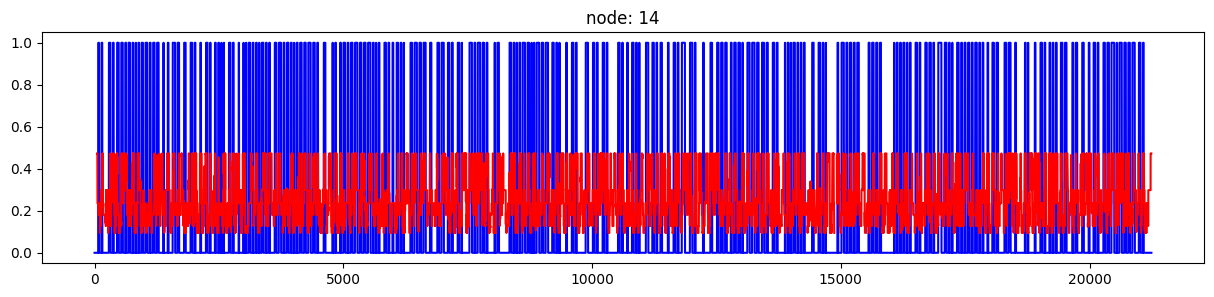

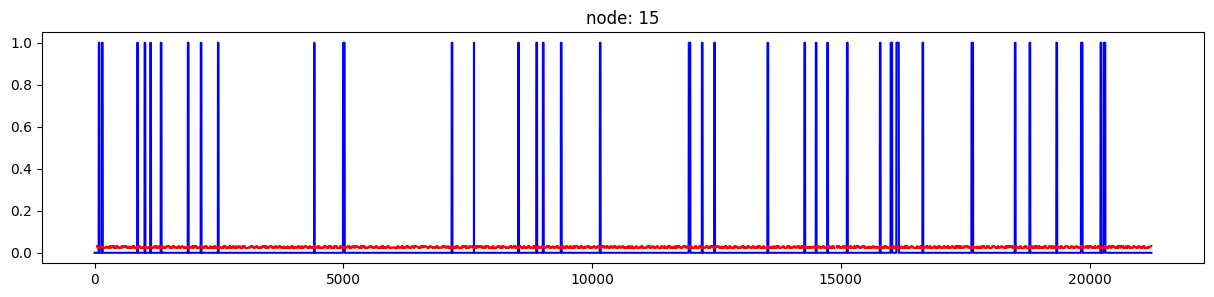

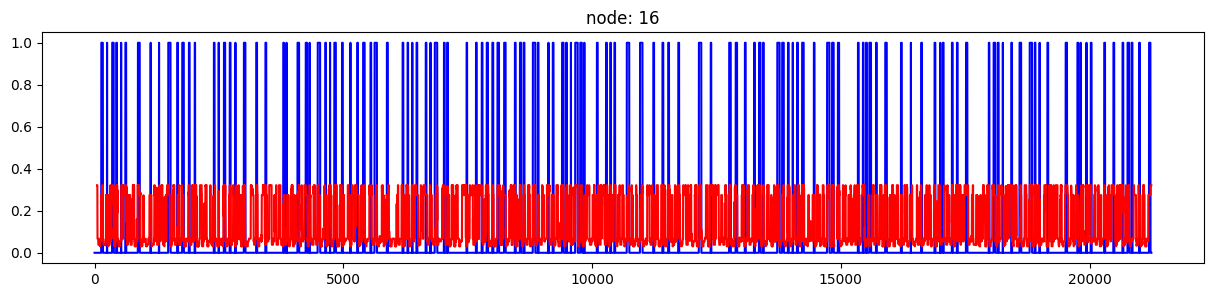

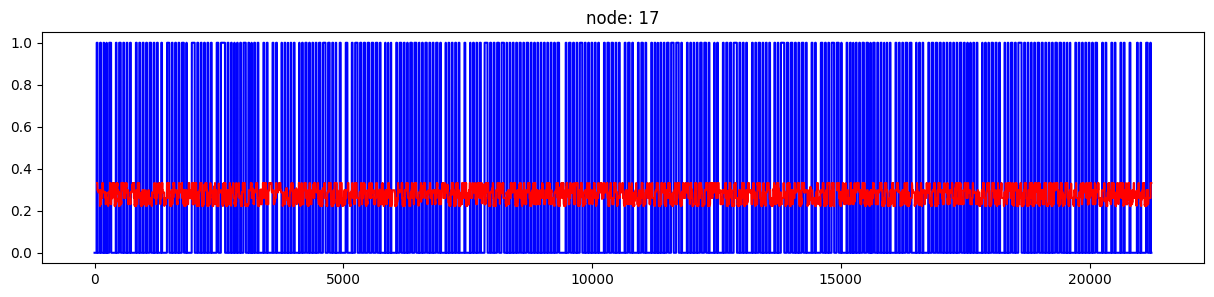

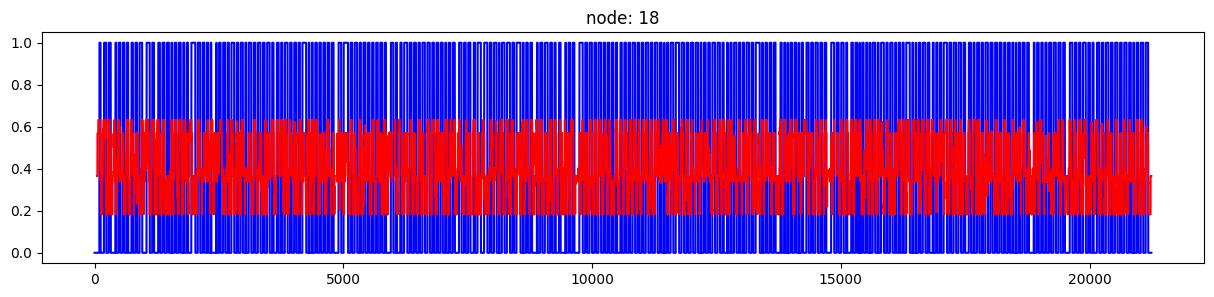

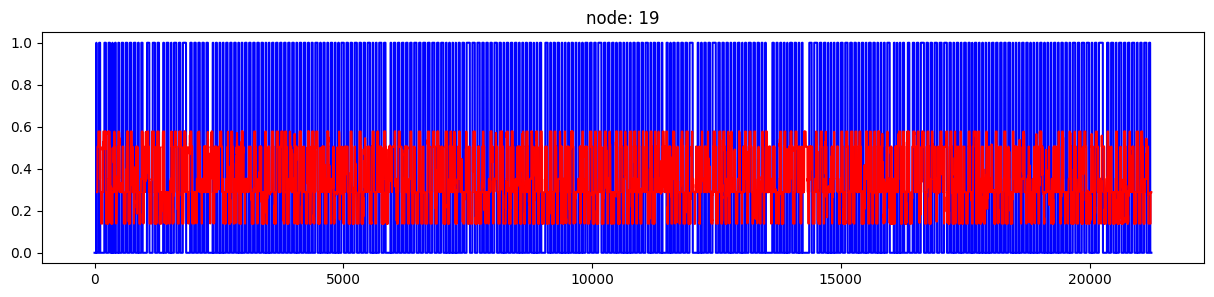

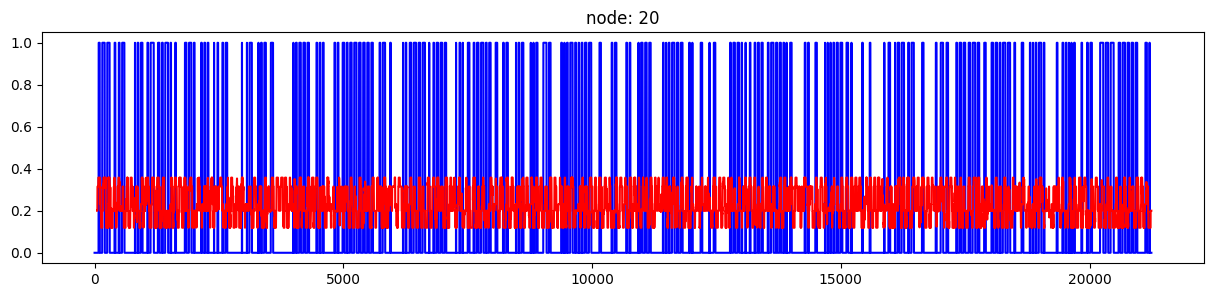

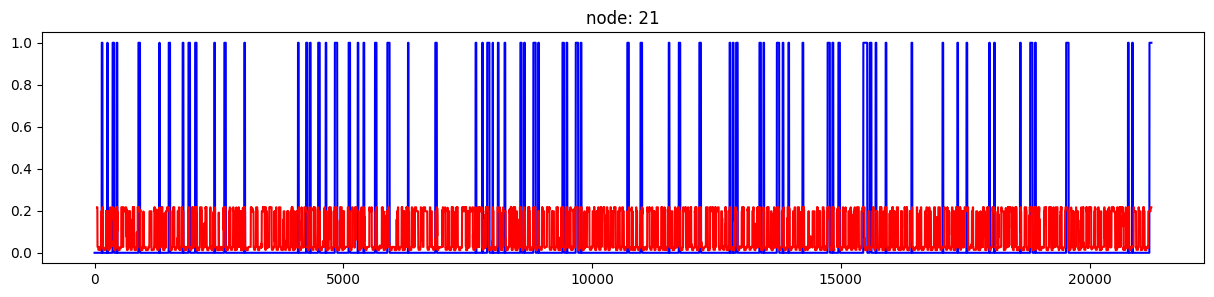

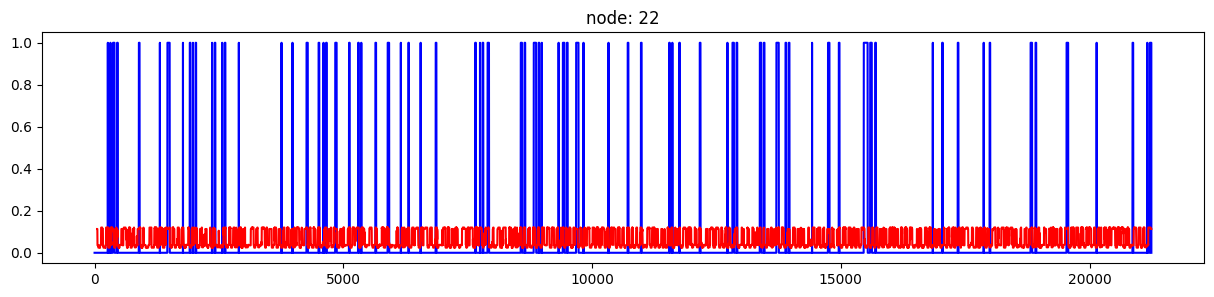

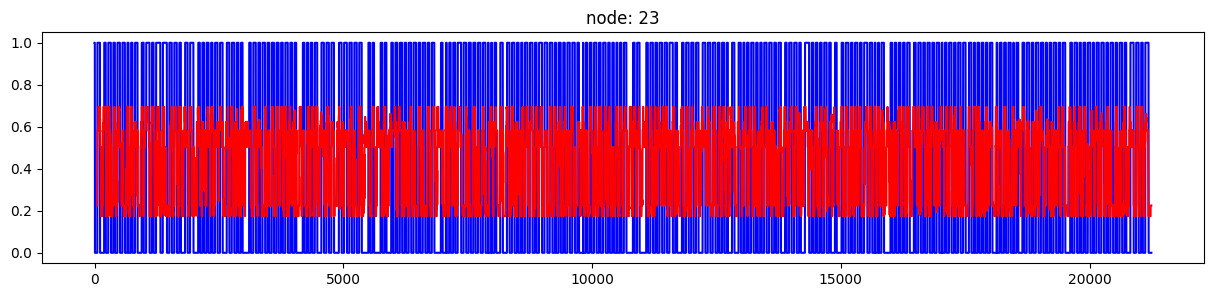

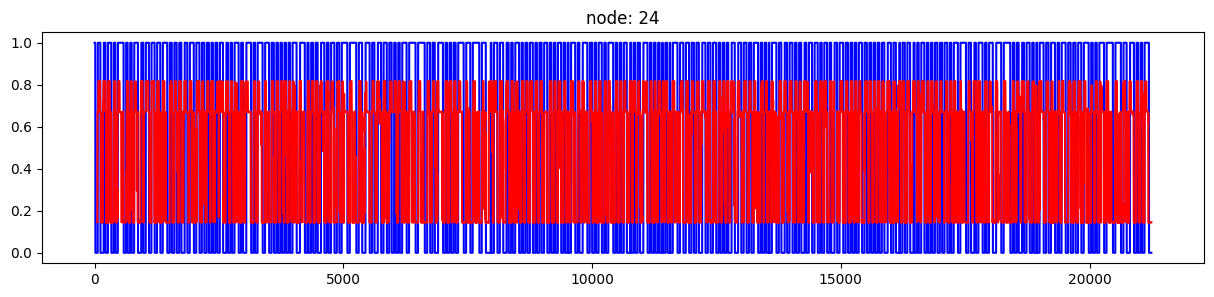

In [259]:
import matplotlib.pyplot as plt

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,N*3:N*4])
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,N*3:N*4])
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset[:,N*3:N*4])-1,:] = testPredict
# plot baseline and predictions
for col in range(0,N-1):
    plt.figure(figsize=(15, 3))
    plt.title('node: ' + str(col+1))
    plt.plot(dataset[:,N*3+col],'b')
    plt.plot(trainPredictPlot[:,col],'r')
    plt.plot(testPredictPlot[:,col],'r')
    plt.show()